In [1]:
import os
os.environ['XLA_PYTHON_CLIENT_PREALLOCATE']='false'

import jax

from jax import random, jit, vmap, grad
from jax import numpy as jnp
from jax.lax import cond

import astropy
import numpy as np
import healpy as hp

import h5py
import astropy.units as u

from astropy.cosmology import Planck15, FlatLambdaCDM, z_at_value
import astropy.constants as constants
from jax.scipy.special import logsumexp
from scipy.interpolate import interp1d
from scipy.stats import gaussian_kde
from tqdm import tqdm

import matplotlib
%matplotlib inline

import matplotlib.pyplot as plt
matplotlib.rcParams['font.family'] = 'Times New Roman'
matplotlib.rcParams['font.sans-serif'] = ['Bitstream Vera Sans']
matplotlib.rcParams['text.usetex'] = False
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['figure.figsize'] = (16.0, 10.0)
matplotlib.rcParams['axes.unicode_minus'] = False

import seaborn as sns
sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('colorblind')
c=sns.color_palette('colorblind')

jax.config.update("jax_enable_x64", True)
jax.config.update('jax_default_matmul_precision', 'highest')


In [2]:
import h5py

filename = 'lognormal_pixelated_nside_64_galaxies'

nside = 64

#biased 0.05, 0.01, 0.005 [0.001 or better unbiased]
with h5py.File(filename + '.h5', 'r') as f:
    zgals = jnp.asarray(f['zgals'])
    dzgals = 0.0001*(1+zgals)
    wgals = jnp.ones(zgals.shape)
    ngals = jnp.asarray(f['ngals'])
    
filename = 'lognormal_pixelated_nside_64_agns'

with h5py.File(filename + '.h5', 'r') as f:
    zagns = jnp.asarray(f['zgals'])
    dzagns = 0.0001*(1+zagns)
    wagns = jnp.ones(zagns.shape)
    nagns = jnp.asarray(f['ngals'])

print(ngals.sum(),nagns.sum())

2025-07-26 23:51:58.204022: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.3 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


10243989 1024266


In [3]:
from jaxinterp2d import interp2d, CartesianGrid

zMax_1 = 0.5
zMax_2 = 5

H0Planck = Planck15.H0.value
Om0Planck = Planck15.Om0

cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Planck15.Om0)
speed_of_light = constants.c.to('km/s').value

zgrid_1 = np.expm1(np.linspace(np.log(1), np.log(zMax_1+1), 5000))
zgrid_2 = np.expm1(np.linspace(np.log(zMax_1+1), np.log(zMax_2+1), 1000))
zgrid = np.concatenate([zgrid_1,zgrid_2])

rs = []
Om0grid = jnp.linspace(Om0Planck-0.1,Om0Planck+0.1,100)
for Om0 in tqdm(Om0grid):
    cosmo = FlatLambdaCDM(H0=H0Planck,Om0=Om0)
    rs.append(cosmo.comoving_distance(zgrid).to(u.Mpc).value)

zgrid = jnp.array(zgrid)
rs = jnp.asarray(rs)
rs = rs.reshape(len(Om0grid),len(zgrid))

@jit
def E(z,Om0=Om0Planck):
    return jnp.sqrt(Om0*(1+z)**3 + (1.0-Om0))

@jit
def r_of_z(z,H0,Om0=Om0Planck):
    return interp2d(Om0,z,Om0grid,zgrid,rs)*(H0Planck/H0)

@jit
def dL_of_z(z,H0,Om0=Om0Planck):
    return (1+z)*r_of_z(z,H0,Om0)

@jit
def z_of_dL(dL,H0,Om0=Om0Planck):
    return jnp.interp(dL,dL_of_z(zgrid,H0,Om0),zgrid)

@jit
def dV_of_z(z,H0,Om0=Om0Planck):
    return speed_of_light*r_of_z(z,H0,Om0)**2/(H0*E(z,Om0))

@jit
def ddL_of_z(z,dL,H0,Om0=Om0Planck):
    return dL/(1+z) + speed_of_light*(1+z)/(H0*E(z,Om0))

100%|██████████| 100/100 [00:00<00:00, 119.30it/s]


In [4]:

with h5py.File('../lognormal_pixelated_gws.h5', 'r') as inp:
        nsamps = inp.attrs['nsamp']
        nEvents_ = inp.attrs['nobs']
        ra = jnp.array(inp['ra'])
        dec = jnp.array(inp['dec'])
        m1det = jnp.array(inp['m1det'])
        m2det = jnp.array(inp['m2det'])
        dL = jnp.array((jnp.array(inp['dL'])*u.Mpc).value)


nsamp = 128
nEvents = 1000
ra = ra.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dec = dec.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
m1det = m1det.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
m2det = m2det.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
dL = dL.reshape(nEvents_,nsamps)[0:nEvents,0:nsamp]
print(ra.shape)
ra = ra[0:nEvents].flatten()
dec = dec[0:nEvents].flatten()
m1det = m1det[0:nEvents].flatten()
m2det = m2det[0:nEvents].flatten()
dL = dL[0:nEvents].flatten()

p_pe = jnp.ones(len(dL))

print(nEvents,nsamp)
print(z_of_dL(dL,140,Om0grid[-1]).max())

(1000, 128)
1000 128
2.7930438159586446


In [5]:
import healpy as hp

npix = hp.pixelfunc.nside2npix(nside)
apix = hp.pixelfunc.nside2pixarea(nside)

print(npix)
samples_ind = hp.pixelfunc.ang2pix(nside,np.pi/2-dec,ra)

49152


In [6]:
@jit
def dV_of_z_normed(z,Om0,gamma):
    dV = dV_of_z(zgrid,H0Planck,Om0)*(1+zgrid)**(gamma-1)
    prob = dV/jnp.trapezoid(dV,zgrid)
    return jnp.interp(z,zgrid,prob)


In [7]:
from jax.scipy.stats import norm

mass = jnp.linspace(1, 150, 2000)
mass_ratio =  jnp.linspace(0, 1, 2000)

@jit
def logpm1_peak(m1,mu,sigma):
    pm1 =  jnp.exp(-(mass - mu)**2 / (2 * sigma ** 2))
    pm1 = pm1/jnp.trapezoid(pm1,mass)
    return jnp.log(jnp.interp(m1,mass,pm1))

@jit
def logfq(m1,m2,beta):
    q = m2/m1
    pq = mass_ratio**beta
    pq = pq/jnp.trapezoid(pq,mass_ratio)

    log_pq = jnp.log(jnp.interp(q,mass_ratio,pq))

    return log_pq


In [8]:
@jit
def log_p_pop_pl_pl(m1,m2,mu,sigma,beta):
    log_dNdm1 = logpm1_peak(m1,mu,sigma)
    log_dNdm2 = logpm1_peak(m2,mu,sigma)
    log_fq = logfq(m1,m2,beta)

    return log_dNdm1 + log_dNdm2 + log_fq
@jit
def logdiffexp(x, y):
    return x + jnp.log1p(jnp.exp(y-x))

In [9]:
from jaxinterp2d import interp2d

@jit
def logpcatalog_gals(z, pix, Om0, gamma):
    zs = zgals[pix] 
    ddzs = dzgals[pix]
    wts = wgals[pix]*dV_of_z(zs,H0Planck,Om0)*(1+zs)**(gamma-1)
    ngals = len(zs)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs)), ngals

logpcatalog_gals_vmap = jit(vmap(logpcatalog_gals, in_axes=(0,0,None,None), out_axes=0))

@jit
def logpcatalog_agns(z, pix, Om0, gamma):
    zs = zagns[pix] 
    ddzs = dzagns[pix]
    wts = wagns[pix]*dV_of_z(zs,H0Planck,Om0)*(1+zs)**(gamma-1)
    nagns = len(zs)
    wts = wts/jnp.sum(wts)
    return logsumexp(jnp.log(wts) + norm.logpdf(z,zs,ddzs)), nagns

logpcatalog_agns_vmap = jit(vmap(logpcatalog_agns, in_axes=(0,0,None,None), out_axes=0))

@jit
def logPriorUniverse(z,pix,f,Om0,gamma1,gamma2):
    logpcat_gals, ngals = logpcatalog_gals_vmap(z, pix, Om0, gamma1)
    
    logpcat_agns, nagns = logpcatalog_agns_vmap(z, pix, Om0, gamma2)
    
    lognorm = - jnp.log(nagns + (1-f)*ngals)

    pcat_gals = jnp.exp(jnp.nan_to_num(logpcat_gals,-jnp.inf))
    pcat_agns = jnp.exp(jnp.nan_to_num(logpcat_agns,-jnp.inf))

    logprob = jnp.log(f*nagns*pcat_agns + (1-f)*(nagns*pcat_agns + ngals*pcat_gals)) + lognorm

    return logprob



1.2265958099680985


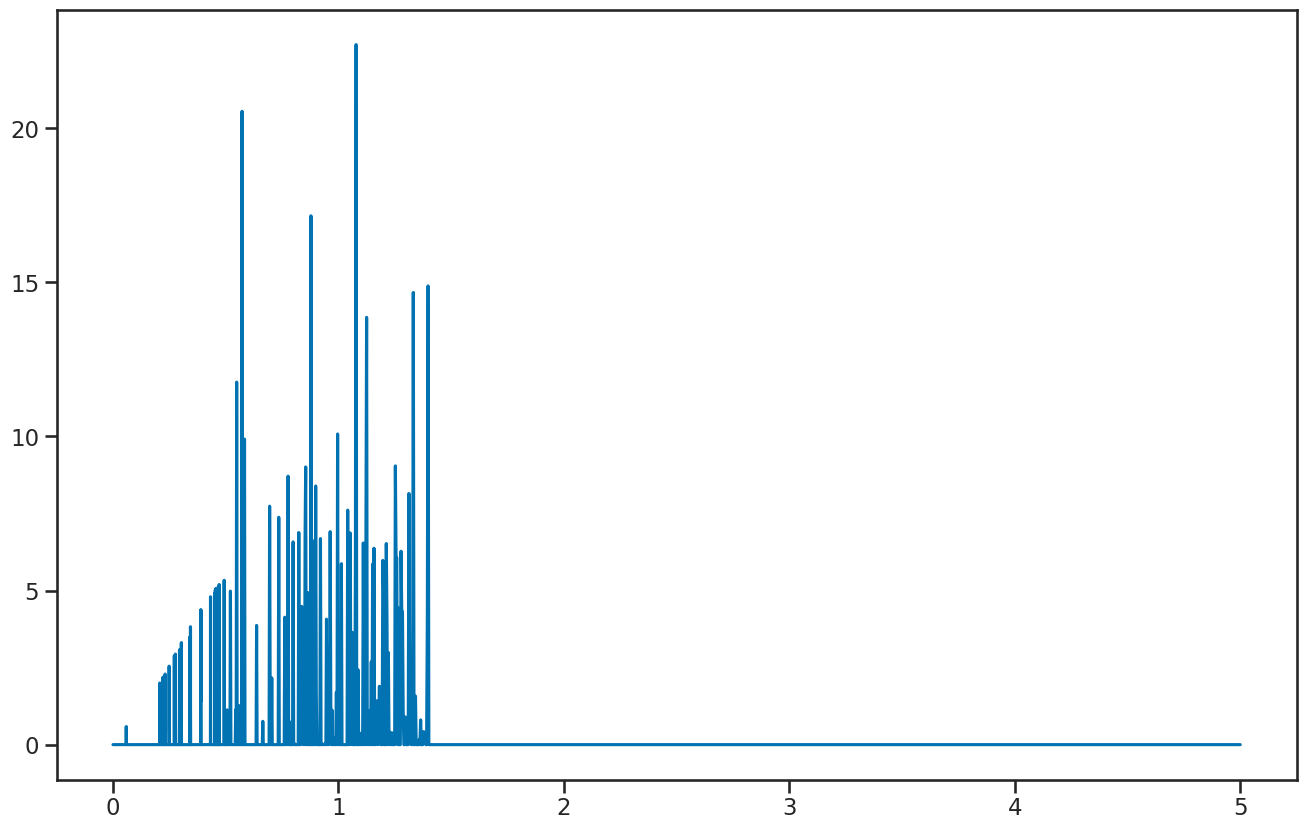

In [10]:
logpcat = logPriorUniverse(zgrid, 53000*np.ones(len(zgrid),dtype=int), 0.5, Om0Planck, 0, 0)
pcat = jnp.exp(logpcat)
print(jnp.trapezoid(pcat,zgrid))
plt.plot(zgrid,pcat)
plt.show()

In [11]:
seed = np.random.randint(1000)
key = jax.random.PRNGKey(1000)

H0 = H0Planck
Om0 = Om0Planck
mu = 35
sigma = 5
beta = 0

@jit
def darksiren_log_likelihood(f,gamma1,gamma2):#,mu,sigma):
    z = z_of_dL(dL, H0, Om0)
    m1 = m1det/(1+z)
    m2 = m2det/(1+z)

    log_weights = log_p_pop_pl_pl(m1,m2,mu,sigma,beta)

    log_weights += - jnp.log(ddL_of_z(z,dL,H0,Om0)) - jnp.log(p_pe) - 2*jnp.log1p(z) + logPriorUniverse(z,samples_ind,f,Om0,gamma1,gamma2)

    log_weights = log_weights.reshape((nEvents,nsamp))
    ll = jnp.sum(-jnp.log(nsamp) + logsumexp(log_weights,axis=-1))
    
    return ll


In [12]:
darksiren_log_likelihood(f=0.8, gamma1=0, gamma2=0)

2025-07-26 23:52:12.640232: E external/xla/xla/service/slow_operation_alarm.cc:65] Constant folding an instruction is taking > 1s:

  %gather.221 = f64[128000,1,300]{2,1,0} gather(f64[49152,300]{1,0} %broadcast.748, s64[128000,2]{1,0} %constant.1177), offset_dims={1,2}, collapsed_slice_dims={}, start_index_map={0,1}, index_vector_dim=1, slice_sizes={1,300}, metadata={op_name="jit(darksiren_log_likelihood)/jit(main)/jit(logPriorUniverse)/jit(logpcatalog_gals)/vmap(jit(logpcatalog_gals))/gather" source_file="/tmp/ipykernel_3057533/2052097892.py" source_line=7}

This isn't necessarily a bug; constant-folding is inherently a trade-off between compilation time and speed at runtime. XLA has some guards that attempt to keep constant folding from taking too long, but fundamentally you'll always be able to come up with an input program that takes a long time.

If you'd like to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
2025-07-26 23:52:13.303480: E exte

Array(-16499.37410898, dtype=float64)

In [13]:
H0_lo = 20
H0_hi = 120

Om0_lo = Om0grid[0]
Om0_hi = Om0grid[-1] 

gamma_lo = -30
gamma_hi = 30

mu_lo = 30
mu_hi = 40

sigma_lo = 3
sigma_hi = 8

f_lo = 0
f_hi = 1.0

beta_lo = 0
beta_hi = 30

lower_bound = [f_lo, gamma_lo, gamma_lo]
upper_bound = [f_hi, gamma_hi, gamma_hi]

ndims = len(lower_bound)
nlive = 200

labels = [r'$f$',
          r'$\gamma_1$', 
          r'$\gamma_2$']#, r'$\beta$']#, 
          #r'$\mu$',r'$\sigma$']#, r'$\beta$']
    
truths = [0.2,0,0]

def prior_transform(theta):
    transformed_params = [
        theta[i] * (upper_bound[i] - lower_bound[i]) + lower_bound[i] 
        for i in range(len(theta))
    ]
    
    return tuple(transformed_params)

def likelihood(coord):
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

def likelihood_emcee(coord):
    for i in range(len(coord)):
        if (coord[i]<lower_bound[i] or coord[i]>upper_bound[i]):
            return -np.inf
    ll = darksiren_log_likelihood(*coord)
    if np.isnan(ll):
        return -np.inf
    else:
        return ll

In [ ]:
import emcee

n_walkers = 64
p0 = np.random.uniform(lower_bound, upper_bound, size=(n_walkers, len(lower_bound)))
n_steps = 5000

sampler = emcee.EnsembleSampler(n_walkers, ndims, likelihood_emcee,
                                moves=[
        (emcee.moves.DEMove(), 0.8),
        (emcee.moves.DESnookerMove(), 0.2),
    ])#, pool=pool)
sampler.run_mcmc(p0, n_steps, progress=True)

 59%|█████▉    | 2953/5000 [3:13:15<2:23:44,  4.21s/it]

In [17]:
shape = sampler.flatchain.shape[0]
print(shape)

dpostsamples_backup = sampler.flatchain[int(shape/2):,:]

shape = dpostsamples_backup.shape[0]
print(shape)
choose = np.random.randint(0,shape,10000)
choose

320000
160000


array([ 16331,  10481,  93743, ...,  93671,  81931, 105917])

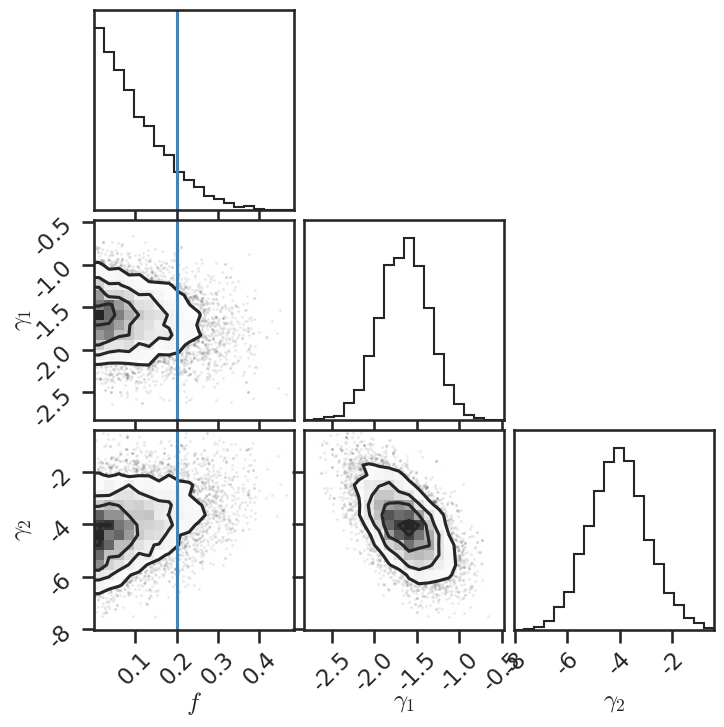

In [18]:
import corner

dpostsamples = dpostsamples_backup[choose]

ranges=[]
for k in range(len(lower_bound)):
    ranges.append((lower_bound[k],upper_bound[k]))
fig = corner.corner(dpostsamples, labels=labels, hist_kwargs={'density': True},truths=truths)
#plt.savefig('corner_ksfmodel.pdf')
plt.show()